<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/StreamTurbines/BladeDesign_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib, subprocess
def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
import pandas as pd

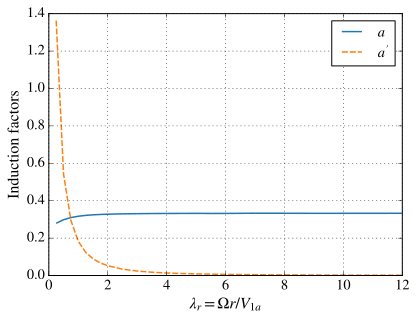

In [3]:
import numpy as np
from scipy.optimize import minimize

def f_objective( X, x ):
    a  = X[0]
    ap = X[1]
    fO = ( 1.0 - a ) * ap * x**3
    return -fO

def f_constraint( X, x ):
    a  = X[0]
    ap = X[1]
    fC = ( 1.0 + ap ) * ap * x**2 - ( 1.0 - a ) * a
    return fC

x_vec = []
a_vec = []
ap_vec = []
CP_vec = []
ϕ_vec = []

X0 = ( 0.2, 1 )

Xset = np.concatenate( ( np.linspace( 0.25, 2.0, 8 ), np.linspace( 2.5, 6.0, 8 ), np.linspace( 7, 12,6 ) ) )

for x in Xset:
    f_objt = lambda X : f_objective( X, x )
    f_cons = lambda X : f_constraint( X, x )

    cons = [ { 'type': 'eq', 'fun': f_cons } ]
    sol = minimize( f_objt, X0, method = 'SLSQP', constraints = cons )
    X0 = sol.x
    a  = sol.x[0]
    ap = sol.x[1]
    CP = (1-a)*ap*x**3

    x_vec.append( x )
    a_vec.append( a )
    ap_vec.append( ap )
    ϕ_vec.append( np.arctan( (1-a)/(1+ap)/x )*180/np.pi )
    CP_vec.append( CP )

mpl.plot( x_vec, a_vec, label = '$a$' )
mpl.plot( x_vec, ap_vec, label = "$a'$" )
mpl.xlabel( "$\lambda_r=\\Omega r/V_{1a}$")
mpl.ylabel( "Induction factors")
mpl.legend()
mpl.grid()
mpl.savefig( "InductionFactors.pdf" )

In [4]:
df = pd.DataFrame( { "$\\lambda_r$": x_vec, "$a$": np.round(a_vec,decimals=5), "$a'$": np.round(ap_vec,decimals=5), "$\\phi$": np.round(ϕ_vec, decimals=2) } )

print( df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.5f}".format,
))

\begin{tabular}{rrrr}
\toprule
$\lambda_r$ & $a$ & $a'$ & $\phi$ \\
\midrule
0.25000 & 0.27945 & 1.36326 & 50.65000 \\
0.50000 & 0.29837 & 0.54278 & 42.29000 \\
0.75000 & 0.30988 & 0.29384 & 35.42000 \\
1.00000 & 0.31699 & 0.18301 & 30.00000 \\
1.25000 & 0.32150 & 0.12419 & 25.77000 \\
1.50000 & 0.32446 & 0.08942 & 22.46000 \\
1.75000 & 0.32647 & 0.06727 & 19.83000 \\
2.00000 & 0.32790 & 0.05235 & 17.71000 \\
2.50000 & 0.32970 & 0.03419 & 14.53000 \\
3.00000 & 0.33075 & 0.02402 & 12.29000 \\
3.50000 & 0.33140 & 0.01777 & 10.63000 \\
4.00000 & 0.33184 & 0.01367 & 9.36000 \\
4.50000 & 0.33213 & 0.01084 & 8.35000 \\
5.00000 & 0.33237 & 0.00880 & 7.54000 \\
5.50000 & 0.33187 & 0.00728 & 6.88000 \\
6.00000 & 0.33208 & 0.00612 & 6.31000 \\
7.00000 & 0.33314 & 0.00451 & 5.42000 \\
8.00000 & 0.33295 & 0.00346 & 4.75000 \\
9.00000 & 0.33251 & 0.00273 & 4.23000 \\
10.00000 & 0.33263 & 0.00221 & 3.81000 \\
11.00000 & 0.33275 & 0.00183 & 3.46000 \\
12.00000 & 0.33281 & 0.00154 & 3.18000 \\
\bottom

In [5]:
def params( X, r ):

    ϕ = X[0]
    c = X[1]
    Z = 3
    σ = Z * c / ( 2 * np.pi * r )

    CL = 1.4
    CD = 0.0
    k = 1.0

    Ca = CL * np.cos(ϕ) + CD * np.sin(ϕ)
    Ct = CL * np.sin(ϕ) - CD * np.cos(ϕ)

    a  = ( σ * Ca ) / ( 4.0 * k * np.sin(ϕ)**2 + σ * Ca )
    ap = ( σ * Ct ) / ( 4.0 * k * np.sin(ϕ)*np.cos(ϕ) - σ * Ct )

    return k, a, ap

def objective( X, r ):
    ϕ = X[0]
    c = X[1]
    k, a, ap = params( X, r )
    fO = k * ap * ( 1.0 - a ) * r**3
    return -fO

def constraint( X, r ):
    ϕ = X[0]
    c = X[1]
    V1a = 2.25
    Ω = 15 * np.pi / 30.0
    k, a, ap = params( X, r )
    fC = np.tan( ϕ ) - ( 1.0 - a ) / ( 1.0 + ap ) * ( V1a / Ω * r )
    return fC

In [6]:
X0 = ( 0.1, 0.5 )

ϕ_bound = ( 0.0, np.pi/2.0 )
c_bound = ( 0.1, 50.0 )

r = 16.0
bnds = ( ϕ_bound, c_bound )
cons = [ { 'type': 'eq', 'fun': lambda X: constraint( X, r ) } ]

sol = minimize( lambda X: objective( X, r ), X0, method = 'SLSQP', bounds = bnds, constraints = cons )

print(sol)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -28994.84138216747
       x: [ 1.018e+00  4.548e+01]
     nit: 18
     jac: [-5.155e+05 -6.540e+03]
    nfev: 58
    njev: 18


In [7]:
sol.x

array([ 1.01812776, 45.48199215])